In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
train_dir = "chest_xray/chest_xray/train"
test_dir = "chest_xray/chest_xray/test"
val_dir = "chest_xray/chest_xray/val"
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_dataset = tf.data.Dataset.from_generator(lambda: train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
train_dataset = train_dataset.repeat()


validation_dataset = tf.data.Dataset.from_generator(lambda: validation,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
validation_dataset = validation_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
test_dataset = test_dataset.repeat()

In [5]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}
#print(weight_for_0,weight_for_1)

In [6]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 45, 45, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 45, 45, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 45, 45, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 45, 45, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 22, 22, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 22, 22, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 22, 22, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 22, 22, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 22, 22, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 22, 22, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 22, 22, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 22, 22, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 22, 22, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 22, 22, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 22, 22, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 11, 11, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 11, 11, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 11, 11, 128)  40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 11, 11, 128)  512        ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 11, 11, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 11, 11, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 11, 11, 32)   36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 11, 11, 480)  0          ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 11, 11, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 11, 11, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 11, 11, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 11, 11, 608)  0          ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 11, 11, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 11, 11, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 11, 11, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 11, 11, 128)  0          ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 11, 11, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 11, 11, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 11, 11, 896)  0          ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 11, 11, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 11, 11, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 11, 11, 1024  0           ['pool4_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool4_conv (Conv2D)            (None, 11, 11, 512)  524288      ['pool4_relu[0][0]']             
          

                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 5, 5, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 5, 5, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 5, 5, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 5, 5, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 5, 5, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 5, 5, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 5, 5, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block13_1_bn (BatchNorma  (None, 5, 5, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 5, 5, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 5, 5, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 5, 5, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
          

In [7]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.65)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
r = model.fit(
    train_dataset, 
    epochs=20,
    validation_data=validation_dataset,
    class_weight=class_weight,
    steps_per_epoch=160,
    validation_steps=32,
)

Epoch 1/20
160/160 [==============================] - 845s 5s/step - loss: 0.1050 - accuracy: 0.8961 - val_loss: 0.4306 - val_accuracy: 0.8438
Epoch 2/20
160/160 [==============================] - 824s 5s/step - loss: 0.0642 - accuracy: 0.9354 - val_loss: 0.5207 - val_accuracy: 0.6875
Epoch 3/20
160/160 [==============================] - 833s 5s/step - loss: 0.0497 - accuracy: 0.9506 - val_loss: 0.5985 - val_accuracy: 0.7188
Epoch 4/20
160/160 [==============================] - 814s 5s/step - loss: 0.0470 - accuracy: 0.9479 - val_loss: 1.4480 - val_accuracy: 0.6875
Epoch 5/20
160/160 [==============================] - 822s 5s/step - loss: 0.0445 - accuracy: 0.9521 - val_loss: 0.8827 - val_accuracy: 0.5938
Epoch 6/20
160/160 [==============================] - 820s 5s/step - loss: 0.0398 - accuracy: 0.9570 - val_loss: 0.4563 - val_accuracy: 0.8125
Epoch 7/20
160/160 [==============================] - 796s 5s/step - loss: 0.0380 - accuracy: 0.9633 - val_loss: 1.9523 - val_accuracy: 0.7500

Text(0.5, 1.0, 'Accuracy Evolution')

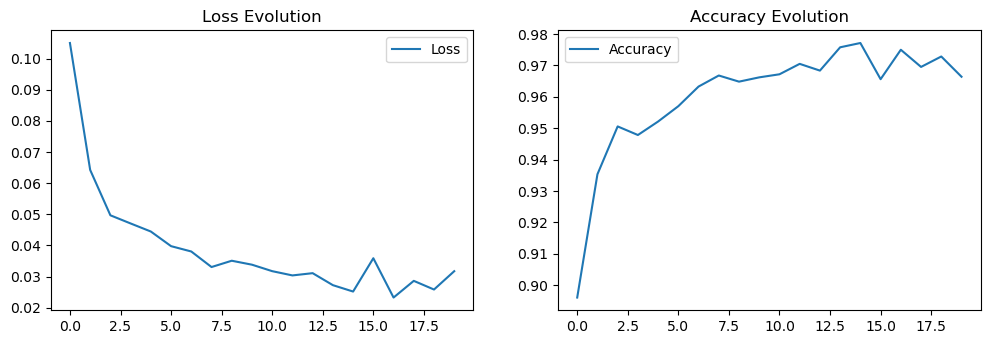

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [10]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")
print(evaluation)
evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 43s 63ms/step - loss: 0.6546 - accuracy: 0.7372
Test Accuracy: 73.72%
[0.6545533537864685, 0.7371794581413269]
163/163 [==============================] - 224s 1s/step - loss: 0.8306 - accuracy: 0.6766
Train Accuracy: 67.66%


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pred = model.predict(test)

conf_mat = confusion_matrix(test.classes, pred > 0.5)
print(conf_mat)

class_report = classification_report(test.classes, pred > 0.5, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)


624/624 [==============================] - 41s 62ms/step
[[220  14]
 [154 236]]
              precision    recall  f1-score     support
0              0.588235  0.940171  0.723684  234.000000
1              0.944000  0.605128  0.737500  390.000000
accuracy       0.730769  0.730769  0.730769    0.730769
macro avg      0.766118  0.772650  0.730592  624.000000
weighted avg   0.810588  0.730769  0.732319  624.000000


In [12]:
model.save('my_model_dnv2.h5')

In [13]:
#91.19/90.24
#83.81/94.90
#87.34/96.43